<a href="https://colab.research.google.com/github/xieruishen/MachineLearningNotebooks/blob/master/MLP_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

G- learning rate e-5 oops didnt write accuracy
G2- epoch 20- 63 ish %
G3- test batch 15, train batch 45 out of memory


In [0]:
#Install Necessary Packages
!pip install torchviz
!pip install pycoco

### Load Libraries

In [0]:
#Import packages to use later
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import gdown
import time

import matplotlib.pyplot as plt
import numpy as np # we always love numpy

### Download Data as Zipfile and Unzip


In [0]:
#Download file from google drive location, then unzip it
from zipfile import ZipFile
import gdown
#'https://drive.google.com/uc?authuser=0&id=1M3doqupItS419I6z-D3rCHUaPo93HbUE&export=download'
# data_zip=gdown.download('https://drive.google.com/uc?authuser=0&id=1Fn29oJ4kT3dp9Hd3NnAicblRRPKg_5XN&export=download',  'asl-alphabet.zip', quiet=False)
# !unzip -qq -o asl-alphabet.zip
# https://drive.google.com/open?id=1aXcpYyR1WiVDnQK4U8QO-BsLwjPnqfMZ
data_zip=gdown.download('https://drive.google.com/uc?authuser=0&id=1aXcpYyR1WiVDnQK4U8QO-BsLwjPnqfMZ&export=download',  'asl-alphabet-processed.zip', quiet=False)
!unzip -qq -o asl-alphabet-processed.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1aXcpYyR1WiVDnQK4U8QO-BsLwjPnqfMZ&export=download
To: /content/asl-alphabet-processed.zip
1.12GB [00:05, 216MB/s]


In [0]:
# Remove delete folder from train data that does not have any test images
!cd asl-alphabet/asl_alphabet_train/asl_alphabet_train && rm -r del

In [0]:
#Check that prev step worked
!ls
!cd asl-alphabet/asl_alphabet_train/asl_alphabet_train && ls

asl-alphabet		    asl_pretrained_modelG.pth  sample_data
asl-alphabet-processed.zip  gdrive
A  C  E  G  I  K  M  nothing  P  R  space  U  W  Y
B  D  F  H  J  L  N  O	      Q  S  T	   V  X  Z


### System Parameters

In [0]:
# Data Metadata-- fixed, does not change
class_len = 28 #26 letters + space and nothing
#mappings give algorithm a look up table to match numbers to letters
class_mappings = {'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'nothing':27}
class_upgrade={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z',26:'space',27:'nothing'}

# Pre-Training Parameters -- based on data being used
image_dims= 3,120,120
n_training_samples=56000 
n_test_samples= 28028
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

# Training Parameters -- parameters to mess with
batch_size = 32 # train
test_batch_size = 5
learning_rate = 3e-5 # 3e-3 didn't work: exploding gradients
n_epochs = 10

### Helper Functions for Data Processing

In [0]:
# Transfer classes into tensors
def get_classes(target):
  class_tensor = torch.zeros((class_len),dtype=torch.long)
  class_tensor[target] = 1
  return class_tensor

# Define a function to show a sample image from the dataset
def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

### Load Training Data

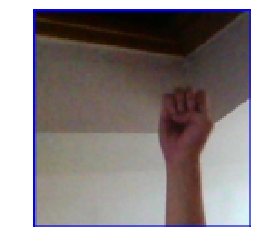

E
torch.Size([3, 120, 120])


In [0]:
#Load in the training set using Image folder to do the cropping, and tensor translation, check it by printing out an image
train_set = ImageFolder(root='asl-alphabet/asl_alphabet_train/asl_alphabet_train/', transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((120,120)),
                                                    transforms.ToTensor()]))
im, target = train_set[9000]
show_image(im)
print(class_upgrade[target])
print(im.shape)

### Load Testing Data

A


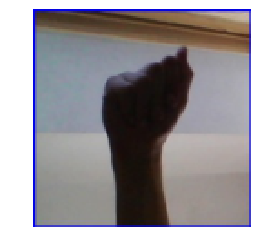

In [0]:
#Same as with training set, use ImageFolder to do preprocessing and load in test set
test_set = ImageFolder(root='asl-alphabet/asl_alphabet_test/asl_alphabet_test/', transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((120,120)),
                                                    transforms.ToTensor()]))

im_test, target_test = test_set[1]
print(class_upgrade[target_test])
show_image(im_test)

In [0]:
# Get our data into batch form
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                        sampler=train_sampler, num_workers=2)
print(train_set.classes)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=test_batch_size, sampler=test_sampler, num_workers=2)
print(test_set.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


### Model Definition

In [0]:
#define the neural net!!
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.activation_func = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 256
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1) # weight learned from each 32 is all different
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,
          stride=1, padding=1) # look at a giant section of the whole image
        # tensor height width and depth
        self.maxpool_output_size = int(256 * (image_dims[1]/40) * (image_dims[2] / 40))
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool2(self.conv3(x)))
        x = self.activation_func(self.pool5(self.conv4(x)))
        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.CrossEntropyLoss()
      #loss = nn.BCEWithLogitsLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

### Model Architecture
Of particular relevance are the blue nodes, which tell you about the various model parameters and layers.

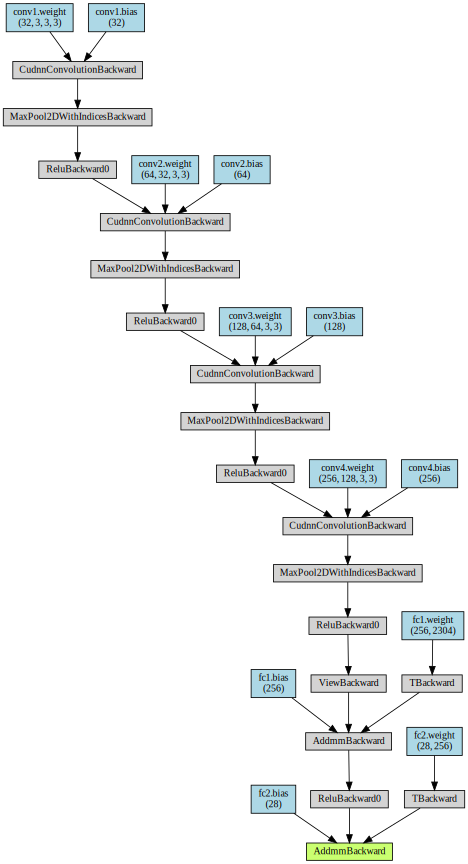

In [0]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net_example = myCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net_example.to(device)

visualize_network(net_example)

### Training & Testing Helper Functions

In [0]:
def convert_targets_to_hot_encoding_for_test(targets):
  targets_tensor = torch.zeros(test_batch_size,28,device=torch.device("cuda"))
  for index in range(test_batch_size):
    targets_tensor[index][targets[index]] = 1
  return targets_tensor

# Get the brute accuracy of our model
# This doesn't really do a good job of characterizing the performance as it is the
# raw accuracy (which includes predicting 0 versus 1 for each class)
def get_acc(output,targets):
    # Get the guess of each class
    output = torch.round(torch.sigmoid(output))
    # Compare guesses
    targets = convert_targets_to_hot_encoding_for_test(targets)
    diff = targets - output
    avg = torch.mean(torch.abs(diff))
    return 1 - avg

def test_loss(run_idx,loss_func,test_hist_x, test_loss_hist):
    # do a pass on the test set
    total_test_loss = 0
    total_acc_loss = 0
    idx = 0
    print(test_loader)
    for inputs, labels in test_loader:
        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss_func(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        total_acc_loss += get_acc(test_outputs, labels)
        if idx >= 300: # Limit testing to 300 images otherwise cuda will run out of memory
          break
        idx += 1
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}".format(
        total_test_loss / (idx+1)))
    print("Validation Accuracy = {:.4f}".format(
        total_acc_loss / (idx+1)))
    
def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    device='cuda'
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    test_every = 200
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

            # Check test set every nth batch
            if (i % test_every) == test_every -1:
              print("index before test_loss:", idx)
              test_loss(idx,loss, test_hist_x, test_loss_hist)

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist, optimizer

In [0]:
print(test_set)

Dataset ImageFolder
    Number of datapoints: 28028
    Root location: asl-alphabet/asl_alphabet_test/asl_alphabet_test/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(200, 200))
               Resize(size=(120, 120), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


### Train Model

In [0]:
# Initialize a model
device='cuda'
net=myCNN()
net.to(device)
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist, optimizer = train_model(net)

### Plot Loss

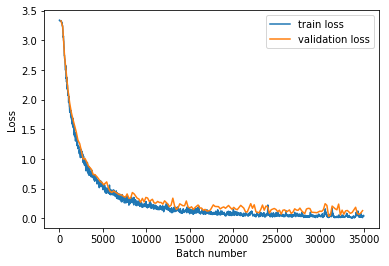

In [0]:
#Makes a plot showing loss versus batch number
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [0]:
print(train_hist_x)
print(train_loss_hist)
print(test_hist_x)
print(test_loss_hist)

[19, 39, 59, 79, 99, 119, 139, 159, 179, 199, 219, 239, 259, 279, 299, 319, 339, 359, 379, 399, 419, 439, 459, 479, 499, 519, 539, 559, 579, 599, 619, 639, 659, 679, 699, 719, 739, 759, 779, 799, 819, 839, 859, 879, 899, 919, 939, 959, 979, 999, 1019, 1039, 1059, 1079, 1099, 1119, 1139, 1159, 1179, 1199, 1219, 1239, 1259, 1279, 1299, 1319, 1339, 1359, 1379, 1399, 1419, 1439, 1459, 1479, 1499, 1519, 1539, 1559, 1579, 1599, 1619, 1639, 1659, 1679, 1699, 1719, 1739, 1769, 1789, 1809, 1829, 1849, 1869, 1889, 1909, 1929, 1949, 1969, 1989, 2009, 2029, 2049, 2069, 2089, 2109, 2129, 2149, 2169, 2189, 2209, 2229, 2249, 2269, 2289, 2309, 2329, 2349, 2369, 2389, 2409, 2429, 2449, 2469, 2489, 2509, 2529, 2549, 2569, 2589, 2609, 2629, 2649, 2669, 2689, 2709, 2729, 2749, 2769, 2789, 2809, 2829, 2849, 2869, 2889, 2909, 2929, 2949, 2969, 2989, 3009, 3029, 3049, 3069, 3089, 3109, 3129, 3149, 3169, 3189, 3209, 3229, 3249, 3269, 3289, 3309, 3329, 3349, 3369, 3389, 3409, 3429, 3449, 3469, 3489, 3519, 3539

In [0]:
net.conv1.weight.shape

torch.Size([32, 3, 3, 3])

### Model Visualization

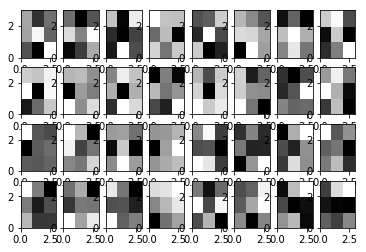

In [0]:
plt.subplots(4, 8)
for i in range(net.conv1.weight.shape[0]):
    plt.subplot(4, 8, i+1)
    kernel = net.conv1.weight[i].cpu().detach().numpy()
    im = kernel.mean(axis=0)
    plt.pcolor(im, cmap='gray')
plt.show()

## Visualization
Now that we have a trianed model, let's see if we can get some insights out of it.  

In this case we examined gradients of different classes with respect to the **inputs** of the model. One way to think about this, if we set the gradient of the output of class `plane` to 1, what pixels played the biggest part in the prediction of that class? AKA what pixels does the Model pay the most attention to when predicting `plane`?

In [0]:
global input_gradients
# Used to grab the gradient
def set_gradient_hook(grad):
    global input_gradients
    input_gradients = grad

# Show an image on a given subplot
def disp_image(image, subplot, label=None, cmap='viridis', correct=True):
    plt.subplot(subplot[0], subplot[1], subplot[2])
    if(cmap != 'viridis'):  
        plt.imshow(image, cmap=cmap,vmin=0, vmax=1)
    else:
        plt.imshow(image, cmap=cmap)
    plt.axis('off')
    truth_phrase = ' GROUND TRUTH' if correct else ' FALSE PREDICTION'
    if(label is not None):
      plt.title("A: " + label + truth_phrase)

# Function that computes the relevant gradient
def get_input_gradient(image, label,net):
    input_img = Variable(image.unsqueeze(0), requires_grad=True).to(device)
    input_img.register_hook(set_gradient_hook)
    model_output = net(input_img)
    #print("input_img", input_img)
    #print("model_output", model_output)
    one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(device)
    one_hot_output[0][label] = 1
    model_output.backward(gradient=one_hot_output)
    grad = np.abs(input_gradients.cpu().numpy()).squeeze()
    #print("grad:",grad)
    # Normalize Heatmap
    grayscale_im = np.sum(grad, axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    #print("grayscale_img", grayscale_im)
    return grayscale_im

# Plot the image, its gradients and the product of the 2 for visualization
def plot_image_row(image, grayscale, label, subplot, correct=True):
    # 1
    #print("grayscale:",grayscale)
    disp_image(grayscale, subplot)
    subplot[2] += 1
    # 2
    masked_img = np.copy(image.transpose(0,2).transpose(0,1).numpy())
    #print(masked_img)
    # Sqrt makes the images easier to see
    masked_img[:,:,0] = masked_img[:,:,0] * grayscale
    masked_img[:,:,1] = masked_img[:,:,1] * grayscale
    masked_img[:,:,2] = masked_img[:,:,2] * grayscale
    disp_image(masked_img, subplot)
    subplot[2] += 1
    # 3
    if label == -1:
        class_label = "sum of all correct classes"
    else:
        class_label = class_upgrade[label]
    disp_image(image.transpose(0,2).transpose(0,1), subplot, class_label, correct=correct)
    subplot[2] += 1
    return subplot

# Plot the gradients and image for every correct class for an image, also plot any incorrect guesses if applicable
def analyse_image(idx,net):
    image, label = test_set[idx]
    logits = net(Variable(image.unsqueeze(0)).to(device)).squeeze()
    #correct_classes = [idx for idx, val in enumerate(label) if val == 1]
    correct_classes = [label]
    max_logit = torch.max(logits).item()
    incorrect_classes = [idx for idx, val in enumerate(logits) if (abs(val - max_logit) <= 1e-3 and idx not in correct_classes)]
    num_plots = len(correct_classes) + len(incorrect_classes) + bool(correct_classes) + bool(incorrect_classes)
    plt.figure(figsize=(16,4 * (num_plots)))
    subplot = [num_plots, 3, 1]
    # Correct
    correct_grayscales = []
    for idx in correct_classes:
        grayscale_correct = get_input_gradient(image, idx,net)
        correct_grayscales.append(grayscale_correct)
        subplot = plot_image_row(image, grayscale_correct, idx, subplot)
    # Incorrect
    incorrect_grayscales = []
    for idx in incorrect_classes:
      idx = incorrect_classes
      grayscale_incorrect = get_input_gradient(image, idx,net)
      incorrect_grayscales.append(grayscale_incorrect)
      subplot = plot_image_row(image, grayscale_incorrect, idx, subplot, False)
    if(len(correct_classes)):
      correct_grayscales = np.array(correct_grayscales)
      correct_grayscales = correct_grayscales.mean(axis=0)
      subplot = plot_image_row(image, correct_grayscales, -1, subplot)
    if(len(incorrect_classes)):
      incorrect_grayscales = np.array(incorrect_grayscales)
      incorrect_grayscales = incorrect_grayscales.mean(axis=0)
      subplot = plot_image_row(image, incorrect_grayscales, -1, subplot, False)

    plt.show()

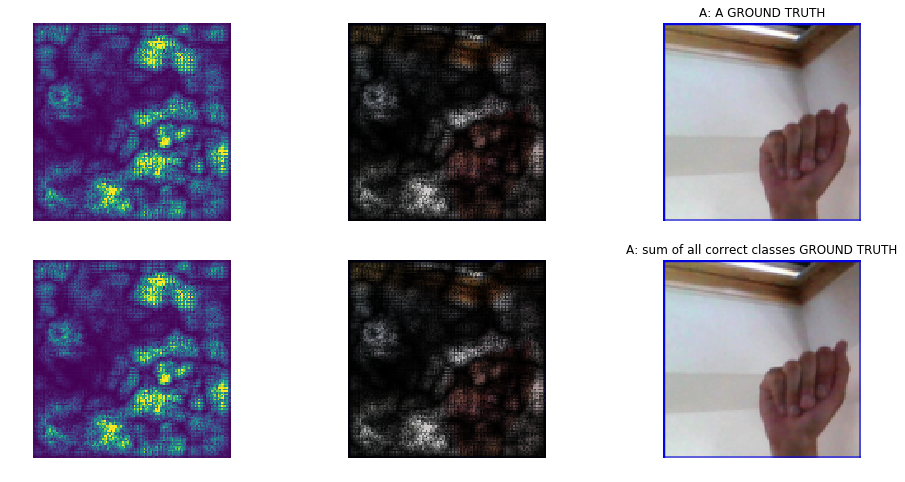

In [0]:
analyse_image(8,net)

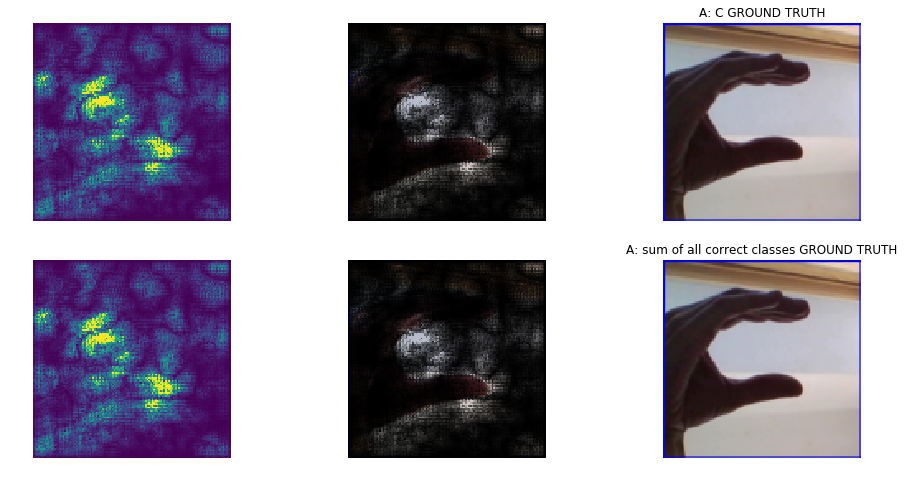

In [0]:
analyse_image(3000,net)

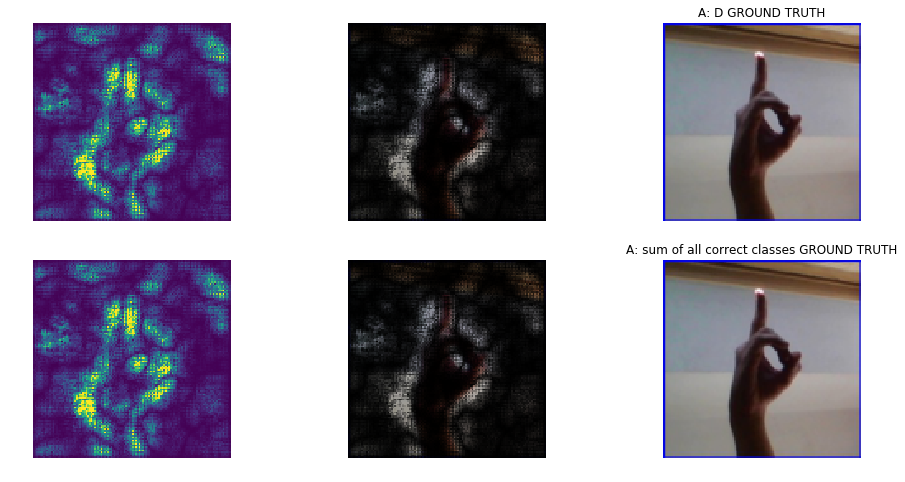

In [0]:
analyse_image(4000,net)

### Save Trained Model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
checkpoint = {'model': myCNN(),
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict()
        }
f = open('/content/gdrive/My Drive/asl_pretrained_modelG2.pth', 'wb')
torch.save(checkpoint, f)
f.close()
from google.colab import files
files.download('/content/gdrive/My Drive/asl_pretrained_modelG2.pth')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type myCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Load Pretrained Model

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1rHf3BlE1y-yr1CkZ_SNKdynwG_6qjuOU&export=download
To: /content/asl_pretrained_modelG.pth
15.8MB [00:00, 32.9MB/s]


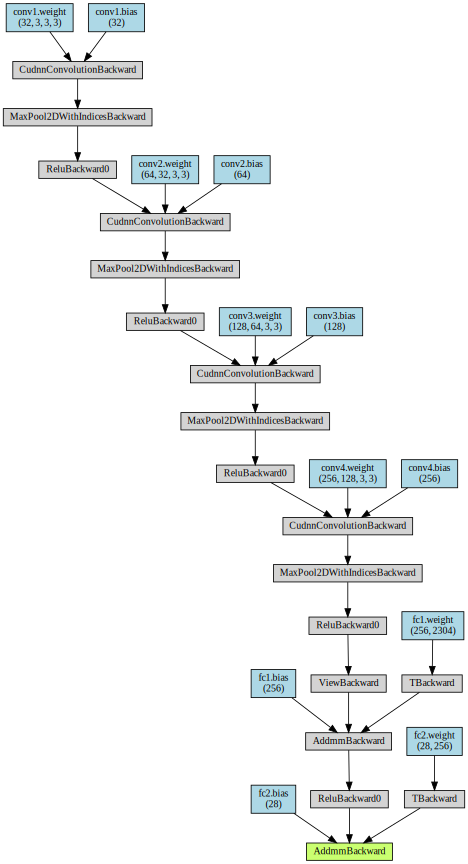

In [0]:
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
pretrained_net = myCNN()

#https://drive.google.com/open?id=1Chm6iTmXErIPYWpnUKIMdUXONuNMmCMg  #asl_pretrained_model1, trained on 87000 images, learning rate 3e-4
#https://drive.google.com/open?id=1rHf3BlE1y-yr1CkZ_SNKdynwG_6qjuOU  #asl_pretrained_model2, trained on 56000 images, learning rate 3e-5
#https://drive.google.com/open?id=1rHf3BlE1y-yr1CkZ_SNKdynwG_6qjuOU  #asl_pretrained_modelG, trained on 56000 images, learning rate 3e-5

#gdown.download('https://drive.google.com/uc?authuser=0&id=1Chm6iTmXErIPYWpnUKIMdUXONuNMmCMg&export=download','asl_pretrained_model1.pth',quiet=False)
#gdown.download('https://drive.google.com/uc?authuser=0&id=1Chm6iTmXErIPYWpnUKIMdUXONuNMmCMg&export=download','asl_pretrained_model1.pth',quiet=False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1rHf3BlE1y-yr1CkZ_SNKdynwG_6qjuOU&export=download',
                'asl_pretrained_modelG.pth',
                quiet=False)

#check_point = torch.load('asl_pretrained_model1.pth')
#check_point = torch.load('asl_pretrained_model2.pth')
check_point = torch.load('asl_pretrained_modelG.pth')

pretrained_net.load_state_dict(check_point['state_dict'])

# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
pretrained_net.to(device)

# Visualize the architecture of the model
# We need to give the net a fake input for this library to visualize the architecture
fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
outputs = pretrained_net(fake_input)
# Plot the DAG (Directed Acyclic Graph) of the model
make_dot(outputs, dict(pretrained_net.named_parameters()))

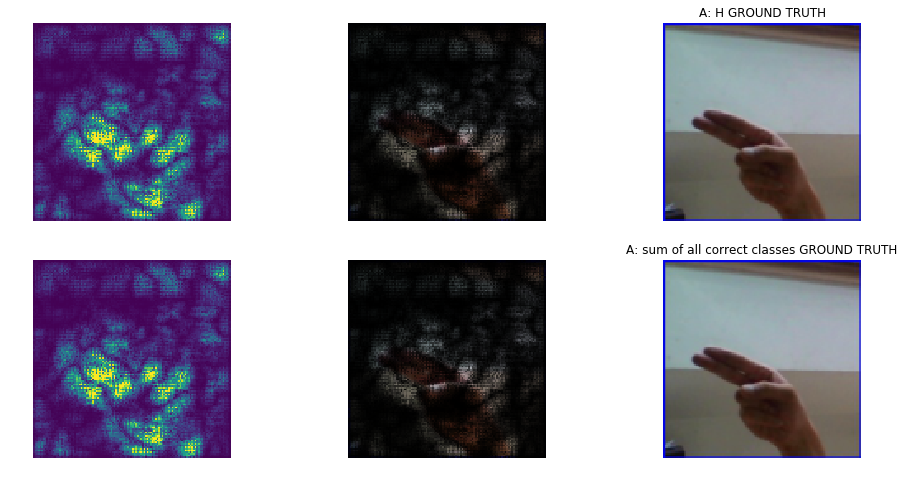

In [0]:
analyse_image(8000,pretrained_net)

Need to do:
- change test set to have more images
- change model based on result from test loss: overfitting vs good enough
- increase resolution of filters
- increase model complexity so it can learn more
- implement regularization

In [0]:
# #### sadness ####

# from torch.utils.data import Dataset
# from PIL import Image
# from torchvision.datasets import VisionDataset
# import os
# from glob import glob
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# def show_image(img_tensor):
#     # need to reorder the tensor dimensions to work properly with imshow
#     plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
#     plt.axis('off')
#     plt.show()

# # Datasets must always subclass either Dataset (either directly or indirectly)
# # Here, we use subclass the VisionDataset class, which is more standard for
# # computer vision datasets.
# class Caltech256(VisionDataset):
#     def __init__(self, transform=None, target_transform=None):
#         # make sure to call the super class init method
#         super(Caltech256, self).__init__('.',
#                                          transform=transform,
#                                          target_transform=target_transform)
        
#         # we'll keep track of the categories here
#         self.categories = []
#         # the index will help us find the jpegs to load
#         self.index = []
#         # the y list will be used to determine the object category
#         self.y = []
#         # all of the data is extracted to the 256_ObjectCategories directory
#         # we search for all files that match ???.* (three characters followed
#         # by a . followed by any string).  This pattern matches all of the
#         # object directories we are interested in parsing.

#         class_mappings = {'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

#         for c in sorted(glob(os.path.join(self.root, "asl_alphabet_train","asl_alphabet_train","*"))):
#             #print(c)
#             # get just the object category directory
#             _, category_dir = os.path.split(c)
#             # convert from 1 index to 0 index class
#             class_idx = class_mappings[category_dir]
#             #print(class_idx)
#             # there is an extra background class that we don't care about
#             # count the jpegs in the appropriate directory
#             img_files = glob(os.path.join(self.root, "asl_alphabet_train","asl_alphabet_train", category_dir, '*.jpg'))
#             n = len(img_files)
#             # populate the categories
#             #self.categories.append(category_dir)
#             self.index.extend(img_files)
#             self.y.extend(n * [class_idx])
#             #print(self.index)

#     def __getitem__(self, index):
#         """
#         Args:
#             index (int): Index
#         Returns:
#             tuple: (image, target) where target is index of the target class.
#         """
#         # load the image using PIL
#         # a gotcha is when some of the images are black and white, we can use
#         # the convert('RGB') command to make sure everything is a three channel
#         # RGB image.
#         img = Image.open(self.index[index]).convert('RGB')
#         # the target has been cached in y
#         target = self.y[index]

#         # apply transformations if they exist (this is useful for images)
#         if self.transform is not None:
#             img = self.transform(img)

#         # apply transformations if they exist (this is useful for images)
#         if self.target_transform is not None:
#             target = self.target_transform(target)

#         return img, target

#     def __len__(self):
#         # you need to say how much data you have
#         return len(self.index)


# # center crop 200, 200 pixel patch and then resize to 100 by 100 for
# # computational efficiency
# cal_tech = Caltech256(transform=transforms.Compose([transforms.CenterCrop((200,200)),
#                                                     transforms.Resize((100,100)),
#                                                     transforms.ToTensor()]))

# im, target = cal_tech[2000]
# show_image(im)
# #print(im.shape)

In [0]:
# loss, optimizer = net.get_loss(learning_rate)
# training_start_time = time.time()
# # Loop for n_epochs
# for epoch in range(n_epochs):
#   running_loss = 0.0
#   start_time = time.time()

#   for i, data in enumerate(train_loader, 0):

#     # Get inputs in right form
#     inputs, labels = data
#     inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
    
#     # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
#     optimizer.zero_grad()

#     # Forward pass
#     outputs = net(inputs)
    
#     # Compute the loss and find the loss with respect to each parameter of the model
#     loss_size = loss(outputs, labels)
#     loss_size.backward()
    
#     # Change each parameter with respect to the recently computed loss.
#     optimizer.step()

#     # Update statistics
#     running_loss += loss_size.data.item()
    
#     # Print every 20th batch of an epoch
#     if (i % print_every) == print_every-1:
#         print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
#             epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
#         # Reset running loss and time
#         train_loss_hist.append(running_loss / print_every)
#         train_hist_x.append(idx)
#         running_loss = 0.0
#         start_time = time.time()
#     idx += 1
#     # Check test set every nth batch
#     if (i % test_every) == test_every -1:
#         print("index before test_loss:", idx)
#         test_loss(idx)
# print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [0]:
# import os
# letters={'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'nothing':27}
# for key in letters.keys():
#   # define the name of the directory to be created
#   path = "/content/asl_alphabet_test/asl_alphabet_test/"+key

#   try:
#       os.mkdir(path)
#   except OSError:
#       print ("Creation of the directory %s failed" % path)
#   else:
#       print ("Successfully created the directory %s " % path)
# !cd asl_alphabet_test/asl_alphabet_test && ls
# # 

In [0]:
# import shutil
# #shutil.move("/content/asl_alphabet_test/asl_alphabet_test/A_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/A/A_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/B_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/B/B_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/C_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/C/C_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/D_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/D/D_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/E_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/E/E_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/F_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/F/F_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/G_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/G/G_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/H_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/H/H_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/I_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/I/I_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/J_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/J/J_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/K_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/K/K_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/L_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/L/L_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/M_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/M/M_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/N_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/N/N_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/O_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/O/O_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/P_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/P/P_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Q_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Q/Q_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/R_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/R/R_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/S_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/S/S_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/T_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/T/T_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/U_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/U/U_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/V_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/V/V_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/W_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/W/W_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/X_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/X/X_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Y_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Y/Y_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Z_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Z/Z_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/nothing/nothing_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/space_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/space/space_test.jpg")